# Importiere Daten


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
import os as os
import seaborn as sns

## Funktionen definieren

In [2]:
# def linear_reg(x, m, t):
#     return m*x + t

# def generate_cosine_weight(angles):
#     temp = np.cos(np.radians(angles))
#     cosine_values = temp/np.sum(temp)
#     return cosine_values

# def weigth(arr):
#     return np.multiply(generate_cosine_weight(arr['lat'].values), arr)

In [3]:

def weighting_arr(arr):   # Generates weighting array of cos
    lat = arr['lat']
    element_temp = ~np.isnan(arr.isel(time=0))
    ones_array = xr.ones_like(element_temp, dtype = float)
    cos_array_temp = ones_array * np.cos(np.radians(lat[:]))
    cos_array = cos_array_temp.where(element_temp)
    return cos_array

def weighting(arr, lat_min, lat_max, lon_min = -180, lon_max = 180):
    weight_arr = weighting_arr(arr).sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, lon_max))
    #temp_mask = ~np.isnan(arr.isel(time=1))    
    temp =arr.sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, lon_max))*weight_arr
    return temp.sum(dim= ['lat', 'lon'])/weight_arr.sum()

In [4]:
month_label = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

legend_colors = plt.cm.tab20(range(12))

In [5]:
custom_rc_params_small = {
    'figure.figsize': (8.5, 5),  # Width x Height in centimeters
    'font.size': 12,  # Font size
    # You can add more custom parameters here if needed
}

plt.rcParams.update(custom_rc_params_small)

## Daten importieren

In [6]:
TMin_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmn.dat.nc/cru_ts4.07.1901.2022.tmn.dat.nc'
TMax_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmx.dat.nc/cru_ts4.07.1901.2022.tmx.dat.nc'
TAvg_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmp.dat.nc/cru_ts4.07.1901.2022.tmp.dat.nc'



TMin = xr.open_dataset(TMin_file)
TMax = xr.open_dataset(TMax_file)
TAvg = xr.open_dataset(TAvg_file)

In [7]:
mask_start = pd.to_datetime('1972')
mask_end = pd.to_datetime('2000')
mask_temp = (TMax.sel(time = slice(mask_start, mask_end)).stn > 0)
mask = mask_temp.all(dim=['time'])
del mask_temp

In [8]:
# Filtering DTR and TAvg
TMax = TMax.where(mask)
TMin = TMin.where(mask)
TAvg = TAvg.where(mask)

## Differenz berechnen

In [9]:
# TMin_Lat = TMin.sel(lat = slice(70,84)).mean('lon')
# TMax_Lat = TMax.sel(lat = slice(70,84)).mean('lon')
# TAvg_Lat = TAvg.sel(lat = slice(70,84)).mean('lon')

In [10]:
# angles_in_degrees = TMin_Lat['lat']

# # Convert degrees to radians (cos function in numpy works with radians)
# angles_in_radians = np.radians(angles_in_degrees)

# cosine_values = np.cos(angles_in_radians)

# TMin_Lat.tmn
# weight_fac = len(cosine_values)/np.sum(cosine_values)

# TMin_Lat_temp = TMin_Lat*cosine_values * weight_fac 
# TMax_Lat_temp = TMax_Lat*cosine_values * weight_fac
# TAvg_Lat_temp = TAvg_Lat*cosine_values * weight_fac

In [11]:
TMin_Lat_tot = weighting(TMin, lat_min=0, lat_max= 90)
TMax_Lat_tot = weighting(TMax, lat_min=0, lat_max= 90)
TAvg_Lat_tot = weighting(TAvg, lat_min=0, lat_max= 90)

In [12]:
# TMin_Lat = TMin.mean('lon')
# TMax_Lat = TMax.mean('lon')
# TAvg_Lat = TAvg.mean('lon')

In [13]:
time_values = TMax['time'].values

In [14]:
# TMin_Lat_tot = TMin_Lat.sel(lat = slice(67,90)).mean('lat')
# TMax_Lat_tot = TMax_Lat.sel(lat = slice(67,90)).mean('lat')
# TAvg_Lat_tot = TAvg_Lat.sel(lat = slice(67,90)).mean('lat')

In [15]:
temperature_difference = TMax.tmx - TMin.tmn   # Normale Differenz fü jeden Punkt
#temperature_difference_Lat = TMax_Lat.tmx- TMin_Lat.tmn # Creating lateral difference
temperature_difference_Pol = TMax_Lat_tot.tmx- TMin_Lat_tot.tmn

In [16]:
monthly_mean_DTR = temperature_difference_Pol.resample(time='M').mean()
monthly_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='M').mean()


In [17]:
# daily_mean_DTR = temperature_difference_Pol.resample(time='D').mean()
# daily_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='D').mean()


# daily_mean_DTR['month'] = daily_mean_DTR['time'].dt.month
# daily_mean_TAvg['month'] = daily_mean_TAvg['time'].dt.month


In [18]:

monthly_mean_DTR['month'] = monthly_mean_DTR['time'].dt.month
monthly_mean_TAvg['month'] = monthly_mean_TAvg['time'].dt.month

## Generiere Unterteilungen des Nordpols (Ringe)

In [19]:
# # Creating dict with different averages
# TAvg_mean_dict = {}

# slices = [(70, 75), (75, 80), (80, 84) ]

# # Perform the slicing and calculation for each slice
# for start, end in slices:
#     # Perform the slice and calculate the mean along the 'lat' dimension
#     sliced_data = TAvg_Lat.tmp.sel(lat=slice(start, end)).mean('lat')
#     TAvg_mean_dict[f'{start}-{end}'] = sliced_data

# # Creating dict with different averages
# DTR_mean_dict = {}

# slices = [(70, 75), (75, 80), (80, 84)]

# # Perform the slicing and calculation for each slice
# for start, end in slices:
#     # Perform the slice and calculate the mean along the 'lat' dimension
#     sliced_data = temperature_difference_Lat.sel(lat=slice(start, end)).mean('lat')
#     DTR_mean_dict[f'{start}-{end}'] = sliced_data


Plotten

In [20]:
# # Extract the keys and values from TAvg_mean_dict and DTR_mean_dict
# ta_keys = list(TAvg_mean_dict.keys())

# legend_handles = []

# for i in ta_keys:
#     plt.scatter(TAvg_mean_dict[i], DTR_mean_dict[i], label = i + '°N' )

# plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xlabel('Average temperature [°C]')
# plt.ylabel('Diurnal temperature range [°C]')


# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_diffrentLat_TAvg_scatter.pdf')
# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_diffrentLat_TAvg_scatter.png')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [21]:
DTR_mean_year = temperature_difference_Pol.resample(time = 'Y').mean()
TAvg_mean_year = TAvg_Lat_tot.tmp.resample(time = 'Y').mean()

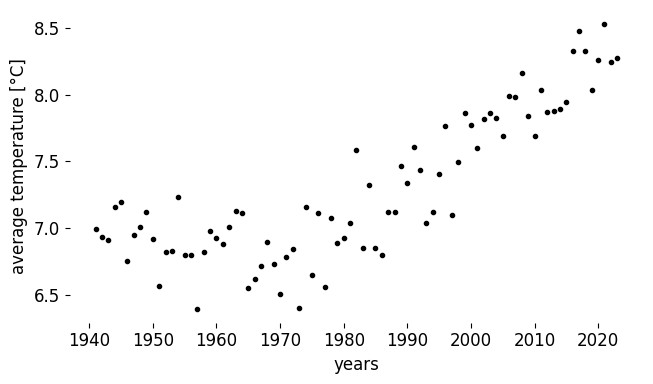

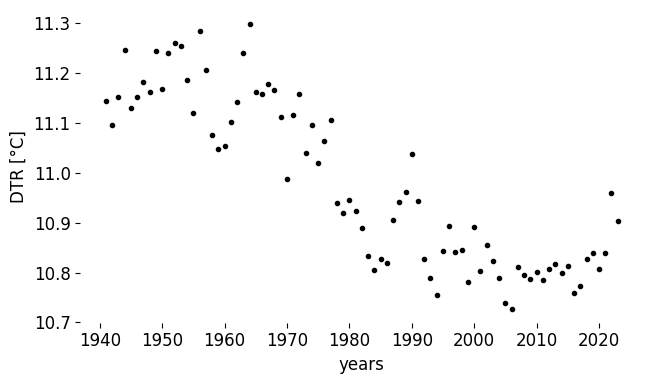

In [33]:
startdate = '1940'

TAvg_mean_year_after_1970 = TAvg_mean_year.sel(time=TAvg_mean_year['time'] >= pd.to_datetime(startdate))

# Create the first plot
fig1, ax1 = plt.subplots(figsize=(17 / 2.54, 4))

# Plot the data for the first plot
ax1.plot(TAvg_mean_year_after_1970.time, TAvg_mean_year_after_1970, marker='.', linestyle='', color='black', label='Average Temperature')
ax1.set_xlabel('years')
ax1.set_ylabel('average temperature [°C]', color='black')

# Set the x-axis limit for the first plot
#ax1.set_xlim(pd.to_datetime('1970',))

# Remove the top and right spines for the first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Add a legend to the first plot
lines1, labels1 = ax1.get_legend_handles_labels()
#ax1.legend(lines1, labels1, loc='best')

# Show the first plot
plt.tight_layout()
plt.savefig('CRU_data_TAvg_yearly_North_0_90_'+str(startdate)+ '.pdf')
plt.savefig('CRU_data_TAvg_yearly_North_0_90_'+str(startdate)+ '.png',dpi = 300)
plt.show()


DTR_mean_year_after_1970 = DTR_mean_year.sel(time=DTR_mean_year['time'] >= pd.to_datetime(startdate))
# Create the second plot
fig2, ax2 = plt.subplots(figsize=(17 / 2.54, 4))

# Plot the data for the second plot
ax2.plot(DTR_mean_year_after_1970.time, DTR_mean_year_after_1970, marker='.', linestyle='', color='black', label='DTR')
ax2.set_xlabel('years')
ax2.set_ylabel('DTR [°C]')

# Set the x-axis limit for the second plot
#ax2.set_xlim(pd.to_datetime('1970',))

# Set the y-axis limits for the second plot
#ax2.set_ylim(7.15, 7.6)

# Remove the top and right spines for the second plot
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Add a legend to the second plot
lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines2, labels2, loc='best')

# Show the second plot
plt.tight_layout()
plt.savefig('CRU_data_DTR_yearly_North_0_90_'+str(startdate)+ '.pdf')
plt.savefig('CRU_data_DTR_yearly_North_0_90_'+str(startdate)+ '.png',dpi = 300)
plt.show()

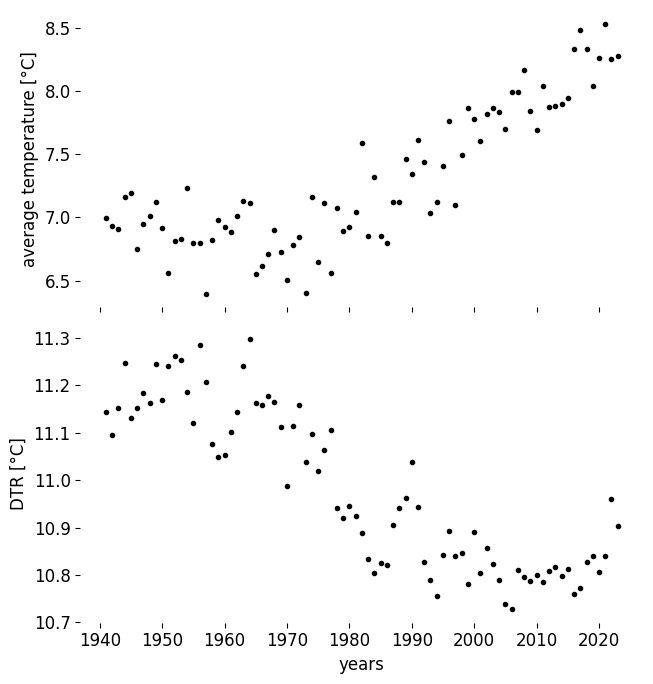

In [34]:

# Filter data for the first plot
TAvg_mean_year_after_1970 = TAvg_mean_year.sel(time=TAvg_mean_year['time'] >= pd.to_datetime(startdate))

# Filter data for the second plot
DTR_mean_year_after_1970 = DTR_mean_year.sel(time=DTR_mean_year['time'] >= pd.to_datetime(startdate))

# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17 / 2.54, 7))

# Plot the data for the first subplot
ax1.plot(TAvg_mean_year_after_1970.time, TAvg_mean_year_after_1970, marker='.', linestyle='', color='black', label='Average Temperature')
ax1.set_ylabel('average temperature [°C]')
ax1.set_xticklabels([])  # Remove x-axis labels for the first subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Plot the data for the second subplot
ax2.plot(DTR_mean_year_after_1970.time, DTR_mean_year_after_1970, marker='.', linestyle='', color='black', label='DTR')
ax2.set_xlabel('years')
ax2.set_ylabel('DTR [°C]')
#ax2.set_ylim(7.15, 7.45)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save or show the plot
plt.savefig('combined_plot_yearly'+str(startdate)+'nomarker_0_90.pdf')
plt.savefig('combined_plot_yearly'+str(startdate)+'nomarker_0_90.png', dpi=300)
plt.show()


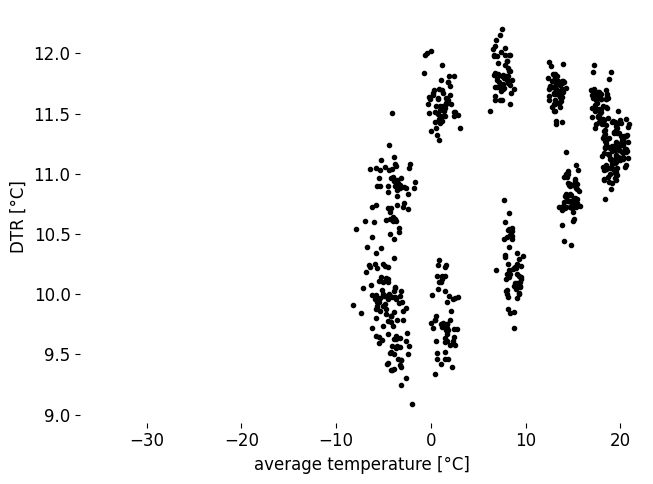

In [24]:
startdate = '1969'

TAvg_Lat_tot_after_1970 = TAvg_Lat_tot.sel(time=TAvg_Lat_tot['time'] > pd.to_datetime(startdate))
DTR_after_1970 = temperature_difference_Pol.sel(time=temperature_difference_Pol['time'] > pd.to_datetime(startdate))




# Create the first plot
fig1, ax1 = plt.subplots(figsize=(17 / 2.54, 5))



# TAvg_Lat.tmp
# Plot the data for the first plot
ax1.plot(TAvg_Lat_tot_after_1970.tmp, DTR_after_1970, marker='.', linestyle='', color='black', label='Average Temperature')
ax1.set_xlabel('average temperature [°C]')
ax1.set_ylabel('DTR [°C]', color='black')

# Set the x-axis limit for the first plot
ax1.set_xlim(-37,)

# Remove the top and right spines for the first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Add a legend to the first plot
lines1, labels1 = ax1.get_legend_handles_labels()
#ax1.legend(lines1, labels1, loc='best')

# Show the first plot
plt.tight_layout()
plt.savefig('CRU_data_TAvg_DTR_month.pdf')
# plt.savefig('CRU_data_TAvg_yearly1970.png',dpi = 300)
plt.show()



In [25]:
month_masks = {}
for month in range(1, 13):
    month_mask = TAvg_Lat_tot_after_1970['time'].dt.month == month
    month_masks[month] = month_mask

In [26]:
# Set the color palette to colorblind
sns.set_palette("colorblind")

# Get the color list from the palette
colors = sns.color_palette()+ ['black', 'lightgreen']

# # Print or use the colors as needed
# print(len(colors))

# fig, ax = plt.subplots()
# for i, color in enumerate(colors):
#     ax.bar(i, 1, color=color, label=f"Color {i+1}")

# ax.set_xticks(range(len(colors)))
# ax.set_xticklabels([f"Color {i+1}" for i in range(len(colors))])
# ax.set_yticks([])
# ax.legend()

# plt.show()

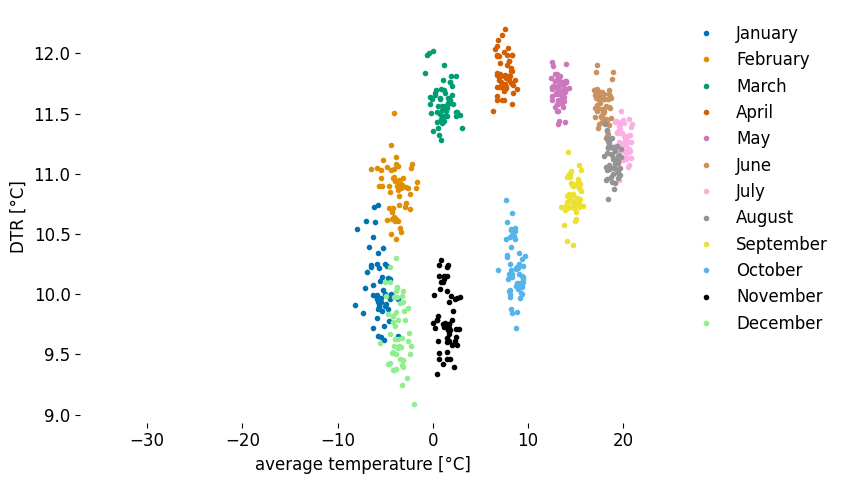

In [27]:
# Create the first plot
fig1, ax1 = plt.subplots(figsize=(22 / 2.54, 5))



# TAvg_Lat.tmp
# Plot the data for the first plot
for i in range(1,13):
    # Apply the mask
    masked_TAvg = TAvg_Lat_tot_after_1970.tmp.where(month_masks[i], drop=True)
    masked_DTR = DTR_after_1970.where(month_masks[i], drop=True)

    # Plot the masked data
    ax1.plot(masked_TAvg, masked_DTR, marker='.', linestyle='', color = colors[i-1], label= month_label[i-1])


# ax1.plot(TAvg_Lat_tot_after_1970.tmp, DTR_after_1970, marker='.', linestyle='', color='black', label='Average Temperature')
ax1.set_xlabel('average temperature [°C]')
ax1.set_ylabel('DTR [°C]', color='black')

# Set the x-axis limit for the first plot
ax1.set_xlim(-37,)

# Remove the top and right spines for the first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Add a legend to the first plot
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)  # Adjust the values based on your layout
# Show the first plot
plt.tight_layout()
plt.savefig('CRU_data_Month_DTR_TAvg_legend.pdf')
plt.savefig('CRU_data_Month_DTR_TAvg_legend.png',dpi = 300)
plt.show()


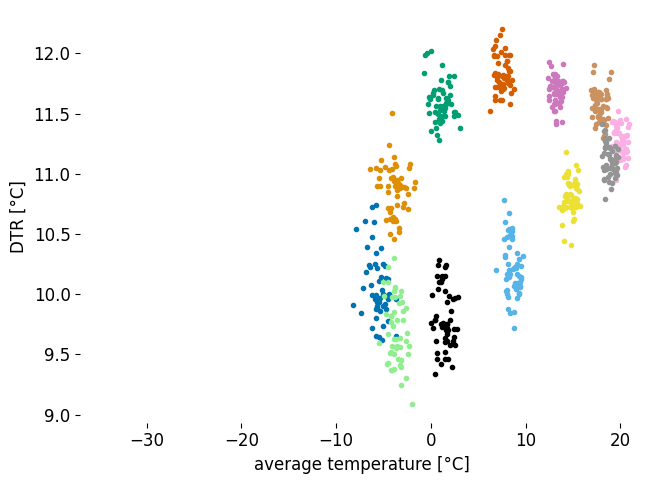

In [28]:
# Create the first plot
fig1, ax1 = plt.subplots(figsize=(17 / 2.54, 5))



# TAvg_Lat.tmp
# Plot the data for the first plot
for i in range(1,13):
    # Apply the mask
    masked_TAvg = TAvg_Lat_tot_after_1970.tmp.where(month_masks[i], drop=True)
    masked_DTR = DTR_after_1970.where(month_masks[i], drop=True)

    # Plot the masked data
    ax1.plot(masked_TAvg, masked_DTR, marker='.', linestyle='', color = colors[i-1], label= month_label[i-1])


# ax1.plot(TAvg_Lat_tot_after_1970.tmp, DTR_after_1970, marker='.', linestyle='', color='black', label='Average Temperature')
ax1.set_xlabel('average temperature [°C]')
ax1.set_ylabel('DTR [°C]', color='black')

# Set the x-axis limit for the first plot
ax1.set_xlim(-37,)

# Remove the top and right spines for the first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Add a legend to the first plot
#ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the values based on your layout
# Show the first plot
plt.tight_layout()
plt.savefig('CRU_data_Month_DTR_TAvg_noLegend.pdf')
plt.savefig('CRU_data_Month_DTR_TAvg_noLegend.png',dpi = 300)
plt.show()
